In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# to visualize on world map in question 2
!pip install geopandas
!pip install geoplot

import geopandas
import geoplot

# Final Assignment - CO2 emissions

---
Assignment for the Winc Academy course

Data Analysis with Python - Hugo Maat

Version 1.0 - 2/3/2022

---

Please formulate an answer to the following three questions in your report.

What is the biggest predictor of a large CO2 output per capita of a country?
which countries are making the biggest strides in decreasing CO2 output?
which non-fossil fuel energy technology will have the best price in the future?

## 1. Biggest predictor of CO2 output

To determine this you may want to consider things like GDP per capita, diets, number of cars per capita, various energy source, mobility and other factors.

Your answer can also be a specific combination of certain factors.

In [22]:
"""
3/3/2022:
I'm writing a function to calculate correlation coefficients, based on the
similar work I did for the Gini vs GDP assignment.
It should take an OurWorldInData table as an argument and return
three different results: 
1): correlation between CO2 Emissions per capita
and the other factor for the entire set; 
2): correlation but per available year,
with a graph (maybe) and statistical information
about the distribution;
3): correlation but per individual country
so that change over time in both values is
compared, with information on the distribution
of values.
"""

emission = pd.read_csv('https://github.com/hugo-maat/Winc_final/raw/main/co-emissions-per-capita.csv',
                       usecols=['Entity','Year','Annual CO2 emissions (per capita)'])
emission.rename(columns={'Annual CO2 emissions (per capita)': 'emissions'}, inplace=True)

emission = emission.loc[emission.Year >= 1970] # half the rows are older than this,
# and 50 years of data should be sufficient for this purpose. 

# Also removing the continents from the dataset
emission = emission.set_index('Entity').drop(['Africa',
                                              'Asia',
                                              'Europe',
                                              'North America',
                                              'Oceania',
                                              'South America',
                                              'World']
                                             ).reset_index()                                

In [24]:
def co2_correlation(df):
    merge = pd.merge(emission, df,
                     on=['Entity','Year'])
    
    factor = df.columns[3] # OurWorldInData formats tables in a certain way,
    # this gets the central factor for most comparison purposes
    timeline = sorted(merge.Year.unique())
    entities = merge.Entity.unique()
    
    correlation1 = merge[['emissions',factor]].corr()
    coefficient1 = correlation1.iloc[0,1]

    correlation2 = merge.groupby('Year')[['emissions', factor]].corr()
    coefficient2 = correlation2.iloc[1::2,0] # returns matrix to series
    coefficient2.index = timeline

    correlation3 = merge.groupby('Entity')[['emissions', factor]].corr()
    coefficient3 = correlation3.iloc[1::2,0]
    coefficient3.index = entities

    print(f"""Correlation between {factor} and CO2 emissions per capita:\n
The Pearson correlation coefficient for the entire set is {round(coefficient1,3)}\n
On a year-by-year basis the coeffient values are distributed as such:\n
{coefficient2.describe()}\n
On basis of geographical entity the coefficient values are distributed as such:\n
{coefficient3.describe()}"""
    )

    return

In [ ]:
gdp = pd.read_csv('https://github.com/hugo-maat/Winc_final/raw/main/gdp-per-capita-maddison-2020.csv')
co2_correlation(gdp) 
# scores well on 1 & 2 less consistent on 3

elect_per_capita = pd.read_csv('https://github.com/hugo-maat/Winc_final/raw/main/per-capita-electricity-consumption.csv')
#co2_correlation(elect_per_capita) 
# performs well on 1 & 2 but less on 3

meat_consumption = pd.read_csv('https://github.com/hugo-maat/Winc_final/raw/main/daily-meat-consumption-per-person.csv')
#co2_correlation(meat_consumption) 
# performs well on 1 & 2 but less on 3

motor_vehicles = pd.read_csv('https://github.com/hugo-maat/Winc_final/raw/main/motor-vehicle-ownership-per-1000-inhabitants.csv')
#co2_correlation(motor_vehicles) 
# does not have historical data but strong correlation for 2014

urbanization = pd.read_csv('https://github.com/hugo-maat/Winc_final/raw/main/urban-vs-rural-majority.csv')
#co2_correlation(urbanization) 
# performs well on 1 & 2 but less on 3

low_carbon_energy = pd.read_csv('https://github.com/hugo-maat/Winc_final/raw/main/share-electricity-low-carbon.csv')
#co2_correlation(low_carbon_energy) 
# not very strong but quite consistent

In [ ]:
# energy sources has more columns than the others
energy_sources = pd.read_csv('https://github.com/hugo-maat/Winc_final/raw/main/primary-energy-source-bar.csv')
sources_list = energy_sources.columns[3:]

for source in sources_list:
    energy_source_df = pd.read_csv('https://github.com/hugo-maat/Winc_final/raw/main/primary-energy-source-bar.csv',
                                   usecols=['Entity', 'Code', 'Year', source])
    co2_correlation(energy_source_df)

# this produces a lot of text but no strong correlations

3/3/2022:

The co2_correlation function appears to be working. There is room for improvement. For instance: is there a way to automate more, and can I get better results, like visualisations, and would that even help?

I found a few very strong correlations already, but I'm certain I haven't exhausted the possibilities. Meat and dairy production both look like useful indicators.

It might be a good idea to start excluding some Entities from the emissions dataframe. I initially let this slide with the expectation that the merge function would get rid of the outliers, but I may want to revisit this when I start narrowing down the potential factors. I'm trying to decide if it's a problem for statistics if the set includes Entities like 'World' and 'Europe' in addition to countries.  

7/3/2022

Not very happy with the correlation approach. I liked it in theory, but I don't get the sense that the results are quite informative yet. Because I'm looking for _predictors_, it might make more sense to try linear regressions. 

The scikit linear regression class actually has prediction methods and coefficients to determine the effectiveness of these predictions.

In [ ]:
from sklearn import linear_model
from sklearn.metrics import r2_score

regr = linear_model.LinearRegression()

def co2_regression(df):
    merge = pd.merge(emission, df,
                     on=['Entity','Year'])
    
    # found this on StackOverflow to randomize the order of rows
    # so that different countries and years are present in the
    # training data
    merge = merge.sample(frac=1)
    
    # the dependent variable or Y will be emissions per capita,
    # the independent variable or X will be the other factor
    factor = df.columns[3]

    # splitting both variables into training and testing data
    # the size of the training data should be relative, let's
    # say 10 %. Size of the independent variable dataset varies
    # per category.
    sample_size = round(len(merge) / 10)

    emission_train = merge.emissions[:sample_size]
    emission_test = merge.emissions[sample_size:]

    factor_train = merge.loc[:,[factor]][:sample_size]
    factor_test = merge.loc[:,[factor]][sample_size:]
    
    fitted = regr.fit(factor_train, emission_train)
    prediction = regr.predict(factor_test)

    plt.scatter(merge.loc[:,factor], merge.emissions, s=0.5, c='blue')
    plt.xlabel(factor)
    plt.ylabel('CO2 emission per capita')
    plt.plot(factor_test, prediction, c='red', lw=0.5)
    plt.title(f'Coefficient of determination for {factor}')

    print(f"""
    Coefficient of determination for {factor}:
    {r2_score(emission_test, prediction)}""")

In [ ]:
independent_variables = [gdp,
                         meat_consumption,
                         elect_per_capita,
                         motor_vehicles,
                         low_carbon_energy,
                         urbanization]

for source in sources_list:
    energy_source_df = pd.read_csv('https://github.com/hugo-maat/Winc_final/raw/main/primary-energy-source-bar.csv',
                                   usecols=['Entity', 'Code', 'Year', source])
    co2_regression(energy_source_df)

for variable in independent_variables:
    co2_regression(variable)

7/3/2022

I am happy with the co2_scatter function, although I should probably rename it. (Renamed it to co2_regression.) Some concerns: the data set is currently ordered (alphabetically and ascending in years) which I worry may affect the outcome. I found a suggestion on StackOverflow to randomize the order of rows using the df.sample method and added it to the function. Won't hurt, and at least the training data won't be skewed towards Afghanistan and other A-countries.

Having run both methods (Pearson correlation with different sampling and a linear regression with predictions measured in determination coefficient) on a selection of different independent variables I have come to the following conclusion: GDP per capita is the strongest predictor for CO2 emission per capita. It consistently has a higher value for coefficient of determination in the regression test than the other independent variables and returns high values on the correlation test as well. Testing for various energy sources returned confusingly low results. I had expected to see stronger patterns there.

Looking at the other 'independent' variables in the selection, I also have the hypothesis that many of these are covariant with GDP per capita. Owning motor vehicles, living in cities, the amount of meat consumed, several of these are associated with economic prosperity. For the final part of question 1 I am going to test that hypothesis using the same methods as above.

In [ ]:
def gdp_regression(df):
    merge = pd.merge(gdp, df,
                     on=['Entity','Year'])
    
    merge = merge.sample(frac=1)
    
    # the dependent variable or Y will be GDP per capita,
    # the independent variable or X will be the other factor
    factor = df.columns[3]

    sample_size = round(len(merge) / 10)

    gdp_train = merge.iloc[:sample_size,3]
    gdp_test = merge.iloc[sample_size:,3]

    factor_train = merge.loc[:,[factor]][:sample_size]
    factor_test = merge.loc[:,[factor]][sample_size:]
    
    fitted = regr.fit(factor_train, gdp_train)
    prediction = regr.predict(factor_test)

    #plt.scatter(merge.loc[:,factor], merge.emissions, s=0.5, c='blue')
    #plt.xlabel(factor)
    #plt.ylabel('CO2 emission per capita')
    #plt.plot(factor_test, prediction, c='red', lw=0.5)

    print(f"""
    Coefficient of determination for {factor}:
    {r2_score(gdp_test, prediction)}""")

for variable in independent_variables[1:]:
    gdp_regression(variable)

... which supports my hypothesis. Amount of motor vehicles, meat consumption, urbanization, access to electricity, all are related to GDP according to the linear regression test. Or, to put it differently, GDP is a predictor for all these factors in the same way that it is a predictor for CO2 emissions per capita. 

## 2. Biggest strides in reducing CO2 output

You'll need to find the relative CO2 output for each country to be able to calculate this. But countries can have growing and shrinking populations too, so it's probably a good idea to take this into account as well.

In [ ]:
"""
8/3/2022

Reading the prompt for question 2 I assume I will need at least two sets to 
start with. CO2 emissions per country and population (growth).
I'm not sure what is meant by relative CO2 output. I don't think it's CO2 per
capita. I will start by changing the absolute values of CO2 emissions per country
into values relative to worldwide CO2 emissions.
"""

emission = pd.read_csv('https://github.com/hugo-maat/Winc_final/raw/main/annual-co-emissions-by-region.csv')
population = pd.read_csv('https://github.com/hugo-maat/Winc_final/raw/main/population.csv')
emission.rename(columns={'Annual CO2 emissions (zero filled)': 'emissions'}, 
                inplace=True)
population.rename(columns={'Population (historical estimates)': 'population'},
                inplace=True)
"""
I think I'll analyze emission grouped by country first,
and then look at adjusting for population.

But first, let's make sure the dataframe only covers countries.
I could try using a generic list of countries instead of manually 
selecting to filter out non-countries. However, I ran into a problem
before when one list had 'United States of America' and the other just
'United States'. I rather spend the extra five minutes reading through
the list of uniques.
"""

emission.Entity.unique() # 'Africa', 'Antarctica', 'Asia', 'Asia (excl. China & India)'
# 'EU-27', 'EU-28', 'Europe', 'Europe (excl. EU-27)', 'Europe (excl. EU-28)',
# 'French Equatorial Africa', 'French Polynesia', 'French West Africa',
# 'International transport', 'Kuwaiti Oil Fires', 'Leeward Islands',
# 'North America', 'North America (excl. USA)', 'Oceania', 'Panama Canal Zone',
# 'South America', 'World'

emission = emission.set_index('Entity').drop(['Africa', 'Antarctica', 'Asia', 
              'Asia (excl. China & India)', 'EU-27', 'EU-28', 'Europe', 
              'Europe (excl. EU-27)', 'Europe (excl. EU-28)',
              'French Equatorial Africa', 'French Polynesia', 
              'French West Africa', 'International transport', 
              'Kuwaiti Oil Fires', 'Leeward Islands', 'North America', 
              'North America (excl. USA)', 'Oceania', 'Panama Canal Zone', 
              'South America', 'World']
              ).reset_index()

"""
Next: countries have not been actively trying to reduce emissions for as long
as we have data. In the second World War CO2 emissions were reduced in the
Netherlands, but we should not interpret that as the result of an 
environmental policy. 
As a starting point, for the time being, I'm using the 1972 publication of the
climate report by the Club of Rome. 
"""

start_year = 1972
df = pd.merge(emission, population, on=['Entity','Code','Year']).drop(columns='Code')
df = df.loc[df.Year >= start_year]

"""
There are a lot of rows with a value of 0 for emissions. I am treating 0 as
a null value. I assume a country always has at least some emissions.
"""

df.emissions.replace({0: np.nan}, inplace=True)

In [ ]:
# first calculate relative co2 emissions per country
def relative_co2(col):
    total = col.sum()
    return col / total

by_year_co2 = df.groupby('Year')['emissions'].transform(relative_co2)
df['relative_co2'] = by_year_co2.values

# now track changes in relative co2 values
df['relative_co2_change'] = df.groupby('Entity')['relative_co2'].diff()

# and see which countries have the lowest total value or greatest reduction
df.groupby('Entity')['relative_co2_change'].sum().sort_values()
# (U.S., Russia, Germany, U.K., Ukraine)

In [ ]:
"""
I am not very happy with using relative co2 output values.
Next, I want to have the values for change in CO2 emissions and
population per country. 
I am calculating values relative to 1972 for the time being.
"""

benchmark = df.loc[df.Year == start_year, 
                   ['Entity', 
                    'emissions',
                    'population']
                   ].set_index('Entity')

for index, row in df.iterrows():
    country = df.loc[index,'Entity']
    # choosing benchmarks
    co2_bench = benchmark.loc[country, 'emissions']
    pop_bench = benchmark.loc[country, 'population']
    # calculating relative values to benchmark
    pop_change = df.loc[index,'population'] / pop_bench
    df.loc[index, 'co2_change'] = df.loc[index,'emissions'] / co2_bench
    # adjusting CO2 emissions change for population growth or decline
    df.loc[index, 'co2_change_adjusted'] = df.loc[index,'emissions'] / co2_bench / pop_change

In [ ]:
df.loc[df.Year == 2020, ['Entity','co2_change']].sort_values(by='co2_change')
# there are some odd examples in this list, some very small countries

df.loc[df.Year == 2020, 'population'].describe()
# first quartile is about 50k for population

df.loc[(df.Year == 2020) & (df.population > 50000),
       ['Entity','co2_change']].sort_values(by='co2_change').head(10)

"""
I expected Sweden, I didn't much expect the top three. Though I can make an
educated guess as to how North Korea has been decreasing emissions. As for
Democratic Republic of Congo: there the population has quadrupled while the
CO2 emissions slightly decreased in the period studied.
Here's the problem: I can chart decreasing emissions compared to changes in
population. I cannot however discern from these statistics whether or not 
these changes were the result of environmental policy, instead of some kind
of disastrous devastation in a country.
"""

df.loc[(df.Year == 2020) & (df.population > 50000),
       ['Entity','co2_change','co2_change_adjusted']].sort_values(by='co2_change_adjusted').head(5)

,Entity,co2_change,co2_change_adjusted
2893,Bahamas,0.360681,0.163133
26671,Moldova,0.180109,0.165119
30078,North Korea,0.327480,0.193191
10932,Democratic Republic of Congo,0.821069,0.193634
22817,Liberia,0.670178,0.195390


In [ ]:
top10_reducers = df.loc[(df.Year == 2020) & (df.population > 50000),
       ['Entity','co2_change','co2_change_adjusted']].sort_values(by='co2_change').head(10)
top10_reducers

world = geopandas.read_file(
    geopandas.datasets.get_path('naturalearth_lowres')
)

in_df = world.name.isin(top10_reducers.Entity.unique())
colors = [x == 'red' for x in in_df if x == True]

world.plot(column=in_df, cmap='Paired', figsize=(10,10))

In [ ]:
# combining the above in a function

def top_reducers(year):
    df = pd.merge(emission, population, on=['Entity','Code','Year']).drop(columns='Code')
    df = df.loc[df.Year >= year]
    df.emissions.replace({0: np.nan}, inplace=True)

    benchmark = df.loc[df.Year == year, 
                   ['Entity', 
                    'emissions',
                    'population']
                   ].set_index('Entity')

    for index, row in df.iterrows():
        country = df.loc[index,'Entity']
        # set benchmark values
        co2_bench = benchmark.loc[country, 'emissions']
        pop_bench = benchmark.loc[country, 'population']
        # calculating relative values to benchmark
        pop_change = df.loc[index,'population'] / pop_bench
        df.loc[index, 'co2_change'] = df.loc[index,'emissions'] / co2_bench
        # adjusting CO2 emissions change for population growth or decline
        df.loc[index, 'co2_change_adjusted'] = df.loc[index,'emissions'] / co2_bench / pop_change
    
    first_quantile = df.loc[df.Year == 2020, 'population'].quantile()
    top10_reducers = df.loc[(df.Year == 2020) & (df.population > first_quantile),
        ['Entity','co2_change','co2_change_adjusted']].sort_values(by='co2_change').head(10)
    top10_reducers_adjusted = df.loc[(df.Year == 2020) & (df.population > first_quantile),
        ['Entity','Year','co2_change','co2_change_adjusted']].sort_values(by='co2_change_adjusted').head(10)

    return top10_reducers_adjusted

In [ ]:
# now to do this several times for different starting years

top_reducers1970to2000 = pd.concat([top_reducers(x) for x in range(1970,2001,5)])

In [ ]:
# and finally to see which countries score high on average

top_reducers1970to2000.groupby('Entity')[['co2_change','co2_change_adjusted']].mean().sort_values(by='co2_change_adjusted')

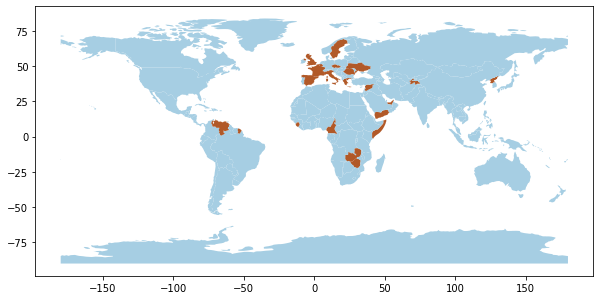

In [ ]:
# which looks like

in_df = world.name.isin(top_reducers1970to2000.Entity.unique())
colors = [x == 'red' for x in in_df if x == True]
world.plot(column=in_df, cmap='Paired', figsize=(10,10))

"""
My point stands: the numbers cannot tell us whether the reduction in
CO2 emissions are the result of environmental policy or disaster.
It's possible to get different results by playing with the parameters,
like setting a different minimum population, to end up with "likely"
biggest reducers, but that would be a confirmation bias.
"""

In [ ]:
# graph workspace for the report
top_reducers1970to2000top5 = df.loc[(df.Year == 2020) & (df.population > 10e6),
       ['Entity','co2_change','co2_change_adjusted']].sort_values(by='co2_change_adjusted').head(5)

top5_values = df.loc[df.Entity.isin(top_reducers1970to2000top5.Entity), 
       ['Entity','Year','emissions']]
top5_values.Entity.unique()

for country in top5_values.Entity.unique():
    country_data = df.loc[df.Entity == country, ['Year','emissions']]
    plt.plot(country_data.Year, country_data.emissions, label=country)

plt.legend(bbox_to_anchor=(1.0,-0.1))
plt.ylabel('CO2 emissions in tons')
plt.yticks([0,1e8,2e8])

just attempts and experiments for question 2 below this line


---



In [ ]:
"""
# now to repeat the calculations for decrease in relative emissions but with
# the adjusted emissions values

by_year_co2_adjusted = df.groupby('Year')['adjusted_emissions'].transform(relative_co2)
df['relative_co2'] = by_year_co2_adjusted.values

# now track changes in relative co2 values
df['relative_co2_change'] = df.groupby('Entity')['relative_co2'].diff()

# and see which countries have the lowest total value or greatest reduction
df.groupby('Entity')['relative_co2_change'].sum().sort_values()

# highest five are the U.S., Germany, Russia, U.K., and France.
"""

In [ ]:
"""
I wonder how much of an impact the timeline has on this.


# function to combine the above steps
def biggest_reduction(year):

    co2 = emission.loc[emission.Year >= year]

    df = pd.merge(co2, population, on=['Entity','Code','Year']).drop(columns='Code')

    benchmark = df.loc[df.Year == year, 
                   ['Entity', 'population']
                   ].set_index('Entity')

    for index, row in df.iterrows():
        country = df.loc[index,'Entity']
        pop_1972 = benchmark.loc[country, 'population']
        df.loc[index, 'relative_pop'] = df.loc[index,'population'] / pop_1972

    df['adjusted_emissions'] = df.emissions / df.relative_pop

    by_year_co2_adjusted = df.groupby('Year')['adjusted_emissions'].transform(relative_co2)
    df['relative_co2'] = by_year_co2_adjusted.values
    df['relative_co2_change'] = df.groupby('Entity')['relative_co2'].diff()
    output = df.groupby('Entity')['relative_co2_change'].sum().sort_values().head(5)
    return output

"""

## 3. Best future price for non-fossil fuel energy

To be able to predict prices you'll probably need to use linear regression over the various non-fossil fuel options.

In [18]:
"""
10/3/2022

Going to be using the 'Levelized cost of energy by technology' chart (LCOE)

Now when we say 'future price', how far into the future do we want to look?
For the data we're using most non-fossil fuel energy sources only come in
around 2010. Most recent figures are at 2019. That's ten measurements. Let's
say therefore that we're going to predict ahead for ten more measurements, up
to 2029. 
"""

lcoe = pd.read_csv('https://github.com/hugo-maat/Winc_final/raw/main/levelized-cost-of-energy.csv')

"""
Besides the figures for LCOE worldwide average estimates there are prices for
a number of countries as well. That might be worth looking at as a part B to this
question: I can imagine that some energy sources are more accessible in certain
parts of the world. Like, for offshore wind power, you need a shore. 

Let's make some adjustments to the dataframe first:
"""

lcoe.drop(columns='Code', inplace=True)
column_names = ['Entity','Year','csp','hydro','solar','onshore','bioenergy','geothermal','offshore']
lcoe.columns = column_names

In [19]:
lcoe_world = lcoe.loc[(lcoe.Year >= 2010)
                      & (lcoe.Entity == 'World')]

lcoe_world

# there is one NaN value in there that trips up the linear regression, have to impute that

lcoe_world = lcoe_world.interpolate()

In [20]:
from sklearn import linear_model

regr = linear_model.LinearRegression()

Text(0, 0.5, 'dollar per kWh')

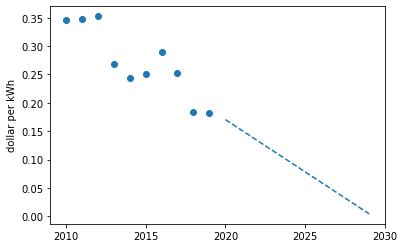

In [21]:
# let's start with one energy source

known_years = np.arange(2010,2020).reshape(-1, 1)
projection = np.arange(2020,2030).reshape(-1, 1)

fitted = regr.fit(known_years, lcoe_world.csp)
prediction = regr.predict(projection)

plt.scatter(known_years, lcoe_world.csp)
plt.plot(projection, prediction, '--')
plt.xticks(range(2010,2031,5))
plt.ylabel('dollar per kWh')

# Alright. Now this is probably not very realistic because the prediction
# ends up at near 0. But the code itself works, so let's write a function.

In [6]:
def energy_price_prediction():
    known_years = np.arange(2010,2020).reshape(-1, 1)
    projection = np.arange(2010,2030).reshape(-1, 1)
    predictions = {}
    for option in lcoe_world.columns[2:]:
        fitted = regr.fit(known_years, lcoe_world[option])
        prediction = regr.predict(projection)
        predictions[option] = list(prediction)
    return pd.DataFrame(data=predictions, index=range(2010,2030))

In [ ]:
# graph of the actual available data
figure = plt.figure(figsize=(12,8))
for x in lcoe_world.columns[2:]:
    plt.plot(known_years, lcoe_world[x], '--', marker='o', label=x)
    plt.legend()

plt.ylim(0,0.4)
plt.ylabel('dollar per kWh')

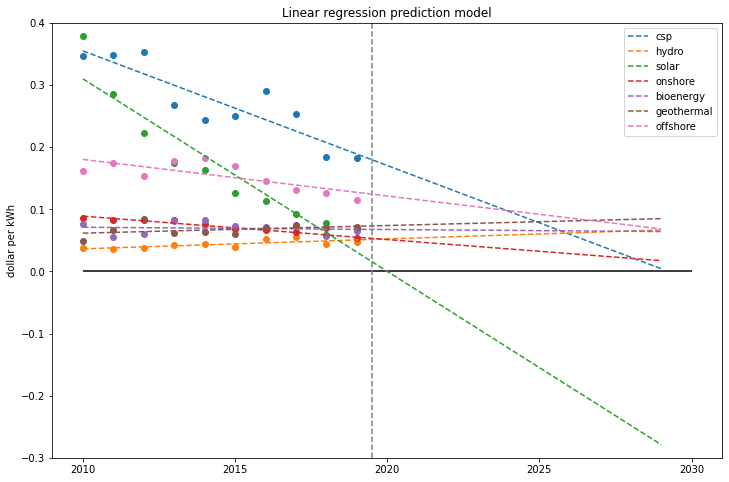

"\nOkay, there's a problem. Using a linear regression model on the past ten years\nin data we could come to the following conclusion: CSP becomes free energy by\nthe year 2029, while regular solar power has negative costs after 2020. That\nwould be great, but it's not realistic. This means that the current approach is\nflawed and normal linear regression is not the method we want to use. \n"

In [8]:
# and the prediction
linear_prediction = energy_price_prediction()

figure = plt.figure(figsize=(12,8))
for x in linear_prediction.columns:
    plt.plot(linear_prediction.index, linear_prediction[x], '--', label=x)
    plt.scatter(known_years, lcoe_world[x])
    plt.legend()

plt.title('Linear regression prediction model')
plt.hlines(0, 2010, 2030)
plt.vlines(2019.5,-0.3,0.4, linestyles='--', colors='gray')
plt.ylabel('dollar per kWh')
plt.xticks(range(2010,2031,5))
plt.ylim(-0.3,0.4)
plt.show()

"""
Okay, there's a problem. Using a linear regression model on the past ten years
in data we could come to the following conclusion: CSP becomes free energy by
the year 2029, while regular solar power has negative costs after 2020. That
would be great, but it's not realistic. This means that the current approach is
flawed and normal linear regression is not the method we want to use. 
"""

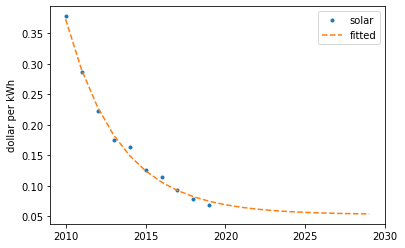

In [10]:
import scipy.optimize
"""
To use the scipy.optimize.curve_fit function I first need to provide a model
function. My assumption here is that energy prices over time are not linear
(because these prices will not become negative) but curved. I searched Google
for an appropriate kind of curve and came upon with exponential decay on the 
website of Scott Harden:
(https://swharden.com/blog/2020-09-24-python-exponential-fit/)

The exponential decay function is not a perfect fit for every energy option. 
It is however a better fit than linear. This way costs will never reach
negative values, which is not possible for LCOE. 
"""

def decay(x, m, t, b):
    return m * np.exp(-t * (x - 2009)) + b # did this to make 2010 count as 1

# p0 values adjusted to something close to eventual optimized parameters
p0 = (0.5,0.2, 0.05)
x = np.array(lcoe_world.Year)
y = np.array(lcoe_world.solar)
params, fitted = scipy.optimize.curve_fit(decay, x, y, p0)
m, t, b = params

# because this fits I can take the parameters
# and use them to extrapolate

x2 = np.arange(2010,2030)
y2 = decay(x2, m, t, b)

plt.plot(x, y, '.', label="solar")
plt.plot(x2, y2, '--', label="fitted")
plt.ylabel('dollar per kWh')
plt.xticks(range(2010,2031,5))
plt.legend()

# lot of work but a lot better! Let's try that as a function...

In [ ]:
def curved_price_prediction(df):
    def decay(x, m, t):
        return m * np.exp(-t * (x - 2009))
    
    x = np.array(df.Year)
    predictions = {}
    for option in df.columns[2:]:
        p0 = (0.5,0.2)
        y = np.array(df[option])
        params, fitted = scipy.optimize.curve_fit(decay, x, y, p0)
        m, t = params
        y2 = decay(np.arange(2010,2030), m, t)
        predictions[option] = y2
    return pd.DataFrame(data=predictions, index=range(2010,2030))

"""
A problem here is that the curve fits solar better than the other distributions.
I was able to write the decay 'function' with a base as fourth argument, but 
several other energy technologies cannot be fitted to that function so I removed
it. This means that the current function assumes that prices will eventually
decay to 0. That seems unrealistic, but will serve for the time being.

In reality, LCOE is determined by the costs of building new power plants as well
as maintaining them, offset against the energy produced and any government
incentives. Therefore a 0 or negative value is not reasonable. The element of
government policies calculated into LCOE also means that all predictions of
future values should be taken with a grain of salt. 

The curved_price_prediction function is not perfect, but it's a lot better
than the linear version ever was. 
"""

In [12]:
"""
Because the exponential decay function with a base value (b) causes errors for 
some of the distributions in the lcoe_world DataFrame I wrote a version that 
resorts to a function without b in case of error in the curve_fit method.
"""

def curved_price_prediction2(df):
    def decay(x, m, t, b):
        return m * np.exp(-t * (x - 2009)) + b
    def decay2(x, m, t):
        return m * np.exp(-t * (x - 2009))
    
    x = np.array(df.Year)
    predictions = {}
    for option in df.columns[2:]:
        try:
            p0 = (0.5,0.2,0.05)
            y = np.array(df[option])
            params, fitted = scipy.optimize.curve_fit(decay, x, y, p0)
            m, t, b = params
            y2 = decay(np.arange(2010,2030), m, t, b)
            predictions[option] = y2
        except:
            p0 = (0.5,0.2)
            y = np.array(df[option])
            params, fitted = scipy.optimize.curve_fit(decay2, x, y, p0)
            m, t = params
            y2 = decay2(np.arange(2010,2030), m, t)
            predictions[option] = y2
    return pd.DataFrame(data=predictions, index=range(2010,2030))

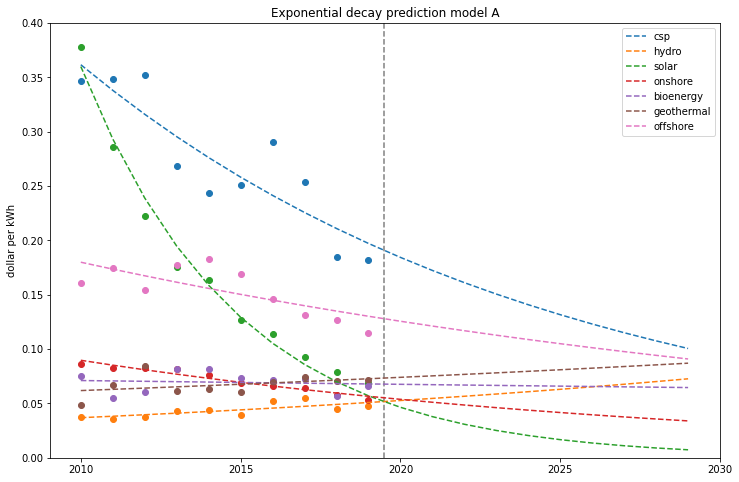

In [13]:
"""
Next step is to plot the predictions from both these functions. I named the
outcome of the regular curved_price_prediction 'model A' and the outcome of the
alternative curved_price_prediction 'model B'. 
"""

prediction_df = curved_price_prediction(lcoe_world)

figure = plt.figure(figsize=(12,8))
for x in prediction_df.columns:
    plt.plot(prediction_df.index, prediction_df[x], '--', label=x)
    plt.scatter(known_years, lcoe_world[x])
    plt.legend()

plt.title('Exponential decay prediction model A')
plt.vlines(2019.5,0,0.4,'gray','--')
plt.ylabel('dollar per kWh')
plt.xticks(range(2010,2031,5))
plt.ylim(bottom=0,top=0.4)
plt.show()

# Would you look at that! It actually worked. 

/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


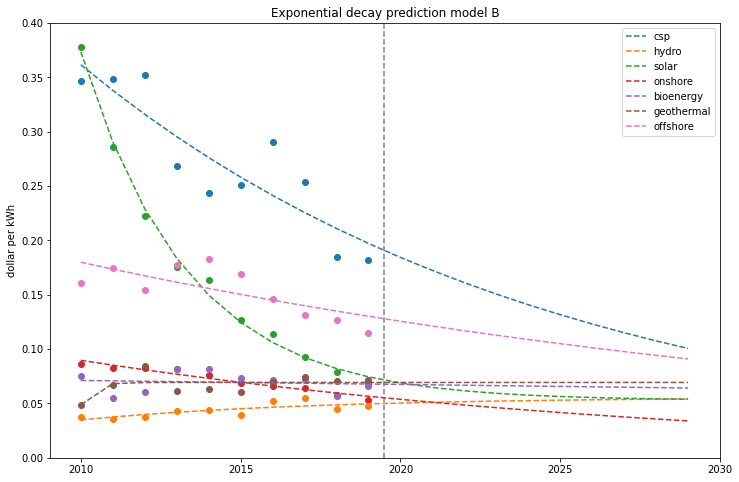

"\nAlthough the resulting graph looks more realistic to me, I don't like the fact\nthat curved_price_prediction2 uses different formulas. There is probably a \npossible function out there that provides a better fit, but at the end of the\nday that's probably not worth the time. This model is good enough for this \npurpose, which is to answer question 3. \nAs far as our predictions for LCOE go: it's likely a tie between onshore wind\nand solar energy (not the concentrated one). On a longer timeline there might\nbe other results, but because of the way LCOE and its factors are determined\nI think it's not reasonable to project that far ahead. \n"

In [14]:
prediction_df2 = curved_price_prediction2(lcoe_world)

figure = plt.figure(figsize=(12,8))
for x in prediction_df2.columns:
    plt.plot(prediction_df2.index, prediction_df2[x], '--', label=x)
    plt.scatter(known_years, lcoe_world[x])
    plt.legend()

plt.title('Exponential decay prediction model B')
plt.vlines(2019.5,0,0.4,'gray','--')
plt.ylabel('dollar per kWh')
plt.xticks(range(2010,2031,5))
plt.ylim(bottom=0,top=0.4)
plt.show()

"""
Although the resulting graph looks more realistic to me, I don't like the fact
that curved_price_prediction2 uses different formulas. There is probably a 
possible function out there that provides a better fit, but at the end of the
day that's probably not worth the time. This model is good enough for this 
purpose, which is to answer question 3. 
As far as our predictions for LCOE go: it's likely a tie between onshore wind
and solar energy (not the concentrated one). On a longer timeline there might
be other results, but because of the way LCOE and its factors are determined
I think it's not reasonable to project that far ahead. 
"""

In [15]:
"""
11/3/2022

-Question 3B-

Now that we have this cool exponential decay curve fit algorithm thing, might as 
well see if we can apply it to some of the LCOE values we have for single
countries rather than the worldwide estimates.
Only 'solar' and 'onshore' (wind) are available for individual countries, and
not even all of them. That's too bad, I had hoped for some comparisons based
on geographical differences.
I am only going to use China, France, Germany, India, UK, and US. These six
have values for both energy sources in the years 2010 through 2019.
"""

country_list = ['China', 'France', 'Germany', 
                'India', 'United Kingdom', 'United States']

lcoe_countries = lcoe.loc[(lcoe.Entity.isin(country_list)) &
                          (lcoe.Year >= 2010),
                          ['Entity','Year','solar','onshore']]

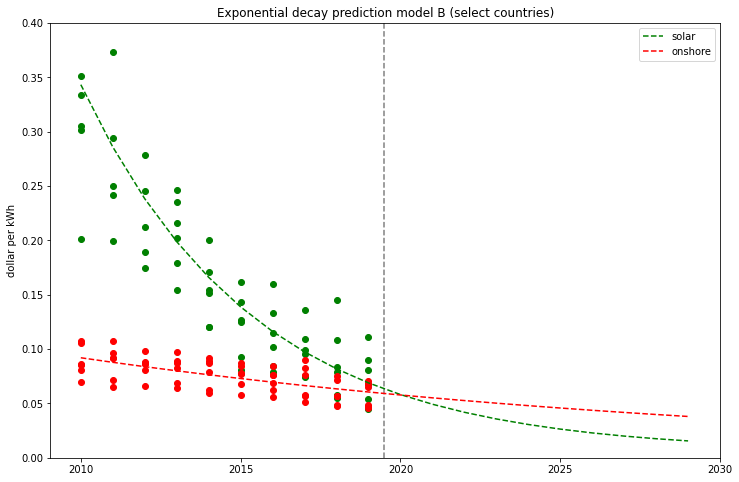

'\nYeah that matches. \n'

In [16]:
prediction_countries = curved_price_prediction2(lcoe_countries)

figure = plt.figure(figsize=(12,8))
for x in prediction_countries.columns:
    colors = 'g' if x == 'solar' else 'r'
    plt.plot(prediction_countries.index, prediction_countries[x], '--', label=x, color=colors)
    plt.scatter(lcoe_countries.Year, lcoe_countries[x], color=colors)
    plt.legend()

plt.title('Exponential decay prediction model B (select countries)')
plt.vlines(2019.5, 0, 0.4, 'gray', '--')
plt.ylabel('dollar per kWh')
plt.xticks(range(2010,2031,5))
plt.ylim(bottom=0,top=0.4)
plt.show()

"""
Yeah that matches. 
"""

'\nWell, what do you know. That actually puts onshore wind at a higher price than\nin the other models. \n\nCould not make this work for the older offshore values, that got really weird.\n'

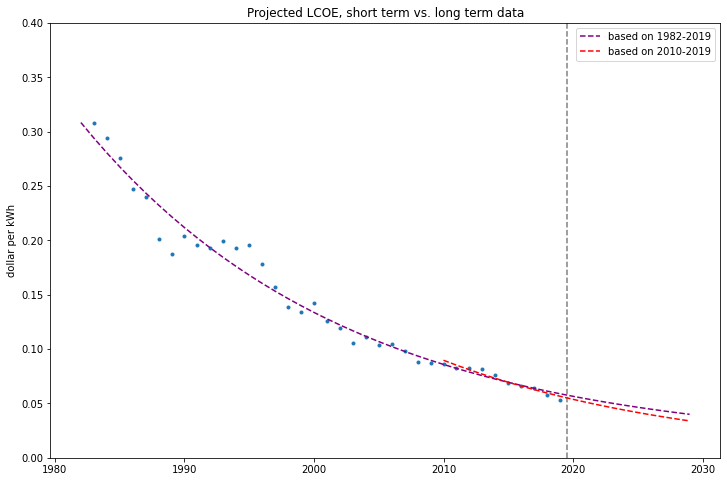

In [17]:
"""
Wanted to try just one last thing, question 3C:
Some energy sources have values from before 2010. Let's see what the longer term
does to the predictions.
"""
lcoe_onshore = lcoe.loc[lcoe.Entity == 'World',['Year','onshore']]

def decay(x, m, t, b):
    return m * np.exp(-t * (x - 1982)) + b
    
x = np.array(lcoe_onshore.Year)
predictions = {}

p0 = (0.5,0.2, 0.1)
y = np.array(lcoe_onshore.onshore)
params, fitted = scipy.optimize.curve_fit(decay, x, y, p0)
m, t, b = params
y2 = decay(np.arange(1982,2030), m, t, b)
predictions['onshore'] = y2
prediction_df3 = pd.DataFrame(data=predictions, index=range(1982,2030))

figure = plt.figure(figsize=(12,8))
plt.plot(x, y, '.')
plt.plot(np.arange(1982,2030), prediction_df3.onshore, '--', label='based on 1982-2019', color='purple')
plt.vlines(2019.5, 0, 0.4, 'gray', '--')
plt.plot(np.arange(2010,2030), prediction_df2.onshore, '--', label='based on 2010-2019', color='r')
plt.ylim(bottom=0, top=0.4)
plt.title('Projected LCOE, short term vs. long term data')
plt.ylabel('dollar per kWh')
plt.legend()


"""
Well, what do you know. That actually puts onshore wind at a higher price than
in the other models. 

Could not make this work for the older offshore values, that got really weird.
"""